#Looking at the Big Picture
##### The first task is to use the New Jersey Realtor's state data to build a model that can predict median housing prices in each municipality using metrics sunch as New Listings, Closed Sales, Days on Market, Percent of Listing Price Received, Inventory of Homes , Months of Supply.

# Framing the Problem
##### Objective: This model's output will be used to feed two other machine learning systems. One will use the predicted median sales price to determine the ARV of a renovated home. The other will determine if it's worth investing in the particular area/municipality

##### Current Solutions: The current solutions are to rely on industry experts (real estate agents and brokers) to manually create Comparable Market Analysis (CMA) which compares the target house to recently solds homes within a 0.5-1 mile radius which have similar property attributes. This method is highly unreliable because there currently isnt an industry standard as how to how to conduct a CMA. Agents are tasked to learn how to conduct this analysis either from other agents or learn by themselves; it is possible that no two agents will produce a similar CMA for the same property because their methodology will be different. In addition to the unreliability of the analysis, it is a very time consuming task and would benefit from being automated by a model.

##### Another solution available is the Zillow Zestimate price. Agents and or consumers will usually use the Zestimate as a trusted source in gauging the value of a target property. However, the model used to create the Zestimate is unknown and we arent certain on how that value is reached, although we are certain that machine learning/deep learning is involved.

# Designing the System

##### My initial bias is to using a multiple regression model because it seems intuitive to use, however, I will approach this project with a true scientists mind. Coming in with zero assumptions and learning as I analyze different models, I will be exploring:
#####1) If the data shows any significant correlation to warrant a machine learning project
#####2) The use of various supervised and unsupervised models which tasks are used to solved reggression problems if there is significant correlation found.

#####This model will learn through batch learning

In [94]:

#  - I can also use a statistical calculation to verify numerically
#   - from statsmodel.stats.diagnostic import het_breuschpagan
#   - _, p_value, _, _ = het_breuschpagan(residuals, X)
# Should I use a Ridge of Lasso Regression?

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
# from sklearn.preprocessing import
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os
import seaborn as sns
from statistics import mean
import warnings


In [95]:
# /content is the default directory of Google Colab. Googel Drive needs to be mounted in order to access the My Drive directory
current_wd = os.getcwd()
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [97]:
# Use in-line SQL magic to connect to PostgreSQL and query the whole dataset instead of using Excel

In [98]:
data = pd.read_excel('NJ 10k Real Estate Data 2024-01-25.xlsx', sheet_name='All Months')
pd.set_option('display.max_columns', None)
# data['Index'] = data['City']
# data.set_index('Index', inplace=True)
data.head()

,City,Dates,County,Quarter,Month,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY)
0,Aberdeen Twp,2019-12-01,Monmouth County,Q4,December,2019,6,-0.625,9,-0.250,40,-0.130,342500,0.000,0.992,-0.001,31,-0.295,2.1,-0.276
1,Aberdeen Twp,2019-11-01,Monmouth County,Q4,November,2019,12,-0.250,21,0.313,48,-0.515,355000,0.043,0.973,0.003,38,-0.240,2.4,-0.314
2,Aberdeen Twp,2019-10-01,Monmouth County,Q4,October,2019,13,-0.235,11,-0.450,84,0.556,380000,0.027,0.973,-0.028,39,-0.188,2.5,-0.242
3,Aberdeen Twp,2019-09-01,Monmouth County,Q3,September,2019,19,-0.136,15,-0.318,56,0.302,376000,0.153,0.974,-0.035,50,-0.138,3.1,-0.244
4,Absecon City,2019-12-01,Atlantic County,Q4,December,2019,11,0.100,18,0.636,83,0.297,190000,-0.050,0.962,-0.003,85,-0.158,6.2,-0.151


In [99]:
# Remove all rows with a value of zero
# Will be using this dataset going forward to train all models
X = data[['City', 'County', 'Quarter', 'Month', 'Year', 'Median Sales Prices', 'New Listings', 'Closed Sales', 'Days on Markets', 'Percent of Listing Price Received', 'Inventory of Homes for Sales', 'Months of Supply']]
# X = data[['Median Sales Prices', 'New Listings', 'Closed Sales', 'Days on Markets', 'Percent of Listing Price Received', 'Inventory of Homes for Sales', 'Months of Supply']]
zeros_removed = X[X != 0]
zeros_removed = zeros_removed.dropna()


In [100]:
# These features are on completely different scales and will require standardization/normalization
zeros_removed.describe(include='all').round(2)

,City,County,Quarter,Month,Year,Median Sales Prices,New Listings,Closed Sales,Days on Markets,Percent of Listing Price Received,Inventory of Homes for Sales,Months of Supply
count,24633,24633,24633,24633,24633.00,24633.00,24633.00,24633.00,24633.00,24633.00,24633.00,24633.00
unique,537,21,4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Washington Twp,Bergen County,Q4,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,197,3175,6945,2515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2021.38,552197.76,15.50,12.68,44.84,1.01,34.84,2.82
std,NaN,NaN,NaN,NaN,1.22,448864.89,16.57,13.69,33.95,0.05,45.04,2.24
min,NaN,NaN,NaN,NaN,2019.00,10000.00,1.00,1.00,1.00,0.57,1.00,0.10
25%,NaN,NaN,NaN,NaN,2020.00,317500.00,5.00,4.00,23.00,0.98,10.00,1.50
50%,NaN,NaN,NaN,NaN,2021.00,449500.00,10.00,8.00,36.00,1.00,20.00,2.20
75%,NaN,NaN,NaN,NaN,2022.00,636250.00,20.00,16.00,56.00,1.03,40.00,3.40


###Feature Engineering

Engineer a few more feature from the current data and explore the trends in the data.

Features I would like to engineer:

1.   Attributable_Sales_PerCounty
2.   'Hot' County
3.   Attributable_Sales_PerCity
4.   'Hot' City
5.   Month over Month (MoM) Growth for all categories

*   What is the Median Sales Price of the hottest/coldest cities?
*   Which counties have the hottest/coldest cities?
*   Which qaurter produces the most sales of all time?
*   What is the median attributed state sales by county
*   What is the median attributed county sales by city
*   What is the median attributed county sales by city
*   For the latest year and quarter, see what the Top 5 hottest/coldest cities are and the numerical change between this quarter and last quarter



In [101]:
def attr_sales_by_county(df, series):
  """
  Accepts a Pandas series of total county sales by month (with the county name as the index)
  and calculates the average attributable percentage of state sales for a county

  :param series:
  :return:
  """
  # Calculate the total sales for the state
  total_state_sales = series.sort_values().sum()
  # Create a list of all the counties to iterate through
  county_list = series.index.to_list()
  df['Total State Sales by Month'] = total_state_sales
  df['Hot or Cold (County Label)'] = 0
  df['Index'] = df['County']
  df.set_index('Index', inplace=True)

  for county in county_list:
    df.loc[county, 'Total County Sales'] = series.loc[county]

  # Label each county as hot or cold based on the the avg attributable sales towards
  # total state sales for that month and if each counties sales are less or greater
  county_sales_per_list = []
  for cumsum in series.to_list():
      county_sales_per_list.append(cumsum / total_state_sales)

  county_sales_avg = mean(county_sales_per_list)
  df['Avg Attr Sales By County'] = county_sales_avg
  df['State Sales Attr. By County'] = df['Total County Sales'] / df['Total State Sales by Month']
  # Calculates a ratio between this months new listings and current existing inventory
  df['NL% of Total Inventory'] = df['New Listings'] / df['Inventory of Homes for Sales']

  # This code works in PyCharm but raises TypeError: 'float' object is not subscriptable in Google Colab. Figure out
  for county in county_list:
    target = df[df['County'] == county]['State Sales Attr. By County'].values
    target_value = target[0]
    if target_value > county_sales_avg:
      # return 'Hot'
      df.loc[county, 'Hot or Cold (County Label)'] = 1
    else:
      pass


  return df

In [142]:
def attr_sales_by_city(target_df, temp_df):
  """
  Accepts two Pandas dfs (main_df and DataFrame.GroupBy object)
  and calculates the average attributable percentage each county's sales by city

  :param target_df:
  :param temp_df:
  :return:
  """
  target_df.reset_index(inplace=True)
  target_df['County Sales Attr. By City'] = target_df['Closed Sales'] / target_df['Total County Sales']
  target_df['State Sales Attr. By City'] = target_df['Closed Sales'] / target_df['Total State Sales by Month']
  quantiles = target_df['State Sales Attr. By City'].quantile([0.50, 0.75])
  target_df['Hot or Cold (City Label)'] = 0
  county_list = target_df['County'].unique().tolist()

  city_sales_avg = target_df['County Sales Attr. By City'].mean()
  # city_sales_attr_state_avg = target_df['State Sales Attr. By City'].mean()
  target_df['Avg Attr Sales By City to County'] = city_sales_avg

  for i in range(len(target_df)):
    if (target_df.loc[i, 'County Sales Attr. By City'] > city_sales_avg) and (target_df.loc[i, 'State Sales Attr. By City'] > quantiles.loc[0.50]):
      target_df.loc[i, 'Hot or Cold (City Label)'] = 1
      # Threshold received during boxplot analysis. The mean is .0014 and the 3rd quartile of State Sales Attr. By City is 0.0026
      # Anything above 2x the 3rd quartile will receive a label of '2'
      if target_df.loc[i, 'State Sales Attr. By City'] >= 2*quantiles.loc[0.75]:
        target_df.loc[i, 'Hot or Cold (City Label)'] = 2

    else:
      target_df.loc[i, 'Hot or Cold (City Label)'] = 0

  return target_df




In [143]:
def month_over_month_data(current_month_df, previous_month_df):

  cities = current_month_df['City'].tolist()
  counties = current_month_df['County'].tolist()
  target_columns = ['Median Sales Prices', 'New Listings', 'Closed Sales', 'Days on Markets', 'Percent of Listing Price Received', 'Inventory of Homes for Sales', 'Months of Supply']
  # The City and County needs to be set as the index because there are multiple cities with the same name.
  # A ValueError is raised in the loop if the correct City cant be distinguished
  current_month_df.set_index(['City', 'County'], inplace=True)
  previous_month_df.set_index(['City', 'County'], inplace=True)
  # warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

  for city, county in zip(cities, counties):
    # mask = current_month_df.loc[(city, county)]
    for column in target_columns:
      if previous_month_df.empty:
        current_month_df.loc[(city, county), column + ' (MoM%)'] = 0
      else:
        try:
          value = (current_month_df.loc[(city, county), column] - previous_month_df.loc[(city, county), column]) / previous_month_df.loc[(city, county), column]
          current_month_df.loc[(city, county), column + ' (MoM%)'] = value
        except KeyError:
          current_month_df.loc[(city, county), column + ' (MoM%)'] = 0

  current_month_df.reset_index(inplace=True)
  return current_month_df


In [144]:
# y = zeros_removed[(zeros_removed['Year'] == 2019) & (zeros_removed['Month'] == 'December')]
# z = zeros_removed[(zeros_removed['Year'] == 2019) & (zeros_removed['Month'] == 'November')]
# results = month_over_month_data(y,z)
# results.tail(50)

In [145]:
def feature_engineering(df):

  years = df['Year'].unique().tolist()
  months = df['Month'].unique().tolist()
  df_list = []

  for year in years:
    year_df = df[df['Year'] == year]
    previous_year_df = df[df['Year'] == year - 1]
    for month in months:
      month_df = year_df[year_df['Month'] == month]
      if month == 'January':
        previous_month_df = previous_year_df[previous_year_df['Month'] == 'December']
      else:
        previous_month = months[months.index(month) - 1]
        previous_month_df = year_df[year_df['Month'] == previous_month]
      if month_df.empty is True:
        continue
      else:
        # Step 1: Calculate the MoM data
        temp_df = month_over_month_data(month_df, previous_month_df)
        temp_df = temp_df.sort_values(by=['Closed Sales'], ascending=False)

        # Step 2: Create a GroupBy Series of the total County sales grouped by County
        total_county_sales_by_month = temp_df.groupby('County')['Closed Sales'].sum()
        temp_df1 = attr_sales_by_county(temp_df, total_county_sales_by_month)

        # Step 3: Create a GroupBy Series of the total County sales grouped by City
        # This is a DataFrame.GroupBy object and will be operated on in the next function
        total_county_sales_by_city = temp_df.groupby(['County', 'City'])['Closed Sales']

        df_list.append(attr_sales_by_city(temp_df1, total_county_sales_by_city))
        # return attr_sales_by_county(month_df, total_county_sales_by_month)

  return pd.concat(df_list)

new_df = feature_engineering(zeros_removed)
new_df.sample(15)
# new_df

<ipython-input-143-b5e2357bc8b2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_month_df.loc[(city, county), column + ' (MoM%)'] = 0
<ipython-input-143-b5e2357bc8b2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_month_df.loc[(city, county), column + ' (MoM%)'] = 0
<ipython-input-143-b5e2357bc8b2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Index,City,County,Quarter,Month,Year,Median Sales Prices,New Listings,Closed Sales,Days on Markets,Percent of Listing Price Received,Inventory of Homes for Sales,Months of Supply,Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Total State Sales by Month,Hot or Cold (County Label),Total County Sales,Avg Attr Sales By County,State Sales Attr. By County,NL% of Total Inventory,County Sales Attr. By City,State Sales Attr. By City,Hot or Cold (City Label),Avg Attr Sales By City to County
122,Cape May County,Cape May City,Cape May County,Q1,February,2021,951500.0,13.0,14.0,60.0,0.978,49.0,4.1,-0.232352,-0.071429,1.333333,0.111111,-0.012121,0.225000,0.205882,5339.0,0,129.0,0.047619,0.024162,0.265306,0.108527,0.002622,1,0.042169
305,Cumberland County,Commercial Twp,Cumberland County,Q3,July,2022,100000.0,2.0,7.0,94.0,0.945,24.0,7.4,1.797203,-0.500000,2.500000,1.043478,0.233681,0.090909,0.104478,7097.0,0,133.0,0.047619,0.018740,0.083333,0.052632,0.000986,0,0.041833
198,Middlesex County,Plainsboro Twp,Middlesex County,Q1,January,2023,905000.0,4.0,6.0,38.0,0.983,11.0,1.3,0.110429,1.000000,0.200000,0.727273,-0.001016,0.222222,0.300000,3634.0,1,295.0,0.047619,0.081178,0.363636,0.020339,0.001651,0,0.043659
68,Bergen County,Ridgewood Village,Bergen County,Q4,November,2022,870000.0,14.0,19.0,30.0,1.048,21.0,0.9,-0.008547,1.000000,-0.269231,0.500000,0.017476,0.400000,0.500000,4973.0,1,480.0,0.047619,0.096521,0.666667,0.039583,0.003821,0,0.042596
389,Monmouth County,Eatontown Boro,Monmouth County,Q3,September,2022,490000.0,8.0,4.0,40.0,0.992,25.0,4.5,-0.057692,-0.111111,-0.333333,0.481481,-0.008000,-0.074074,-0.134615,6544.0,1,573.0,0.047619,0.087561,0.320000,0.006981,0.000611,0,0.041584
277,Bergen County,Englewood Cliffs Boro,Bergen County,Q4,December,2023,1837000.0,1.0,5.0,29.0,0.977,13.0,2.3,0.493496,-0.875000,0.666667,-0.482143,-0.026892,-0.409091,-0.378378,4204.0,1,366.0,0.047619,0.087060,0.076923,0.013661,0.001189,0,0.046053
104,Camden County,Lindenwold Boro,Camden County,Q2,April,2021,195000.0,18.0,19.0,19.0,1.037,17.0,1.4,0.029024,0.500000,0.583333,-0.095238,0.024704,-0.150000,-0.066667,6736.0,1,509.0,0.047619,0.075564,1.058824,0.037328,0.002821,0,0.042254
103,Essex County,Belleville Twp,Essex County,Q2,June,2021,375000.0,32.0,26.0,21.0,1.073,48.0,1.9,-0.062500,0.142857,-0.212121,-0.160000,0.010358,-0.157895,-0.173913,9142.0,1,586.0,0.047619,0.064100,0.666667,0.044369,0.002844,1,0.041016
189,Ocean County,Lavallette Boro,Ocean County,Q1,February,2021,580000.0,15.0,9.0,85.0,0.946,27.0,1.2,-0.393939,-0.531250,-0.250000,1.428571,-0.048290,-0.400000,-0.454545,5339.0,1,554.0,0.047619,0.103765,0.555556,0.016245,0.001686,0,0.042169
52,Union County,Summit City,Union County,Q2,May,2021,1350000.0,32.0,31.0,30.0,1.022,35.0,1.1,0.333992,-0.346939,0.722222,0.034483,0.012884,-0.146341,-0.214286,6849.0,1,403.0,0.047619,0.058841,0.914286,0.076923,0.004526,1,0.042000


In [147]:
new_df.sample(20)

,Index,City,County,Quarter,Month,Year,Median Sales Prices,New Listings,Closed Sales,Days on Markets,Percent of Listing Price Received,Inventory of Homes for Sales,Months of Supply,Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Total State Sales by Month,Hot or Cold (County Label),Total County Sales,Avg Attr Sales By County,State Sales Attr. By County,NL% of Total Inventory,County Sales Attr. By City,State Sales Attr. By City,Hot or Cold (City Label),Avg Attr Sales By City to County
115,Burlington County,Hainesport Twp,Burlington County,Q1,February,2020,235310.0,4.0,6.0,152.0,0.936,17.0,3.3,-0.465205,-0.636364,-0.600000,3.222222,-0.047813,0.062500,0.434783,2104.0,1,165.0,0.047619,0.078422,0.235294,0.036364,0.002852,0,0.093750
255,Morris County,Dover Town,Morris County,Q1,March,2020,279000.0,5.0,7.0,108.0,0.958,12.0,1.5,-0.154545,-0.545455,0.000000,1.918919,-0.052423,-0.454545,-0.464286,5589.0,1,308.0,0.047619,0.055108,0.416667,0.022727,0.001252,0,0.042339
252,Morris County,Morris Plains Boro,Morris County,Q1,March,2022,705000.0,7.0,7.0,16.0,1.026,2.0,0.3,-0.014331,-0.300000,-0.125000,0.600000,-0.096035,-0.818182,-0.833333,5689.0,1,335.0,0.047619,0.058886,3.500000,0.020896,0.001230,0,0.041916
352,Cape May County,Dennis Twp,Cape May County,Q4,October,2019,298000.0,10.0,6.0,48.0,0.968,72.0,9.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6969.0,0,176.0,0.047619,0.025255,0.138889,0.034091,0.000861,0,0.041584
490,Warren County,Hardwick Twp,Warren County,Q2,May,2021,529000.0,3.0,1.0,23.0,1.000,10.0,3.6,0.047525,-0.400000,0.000000,-0.863095,-0.011858,-0.090909,-0.200000,6849.0,0,107.0,0.047619,0.015623,0.300000,0.009346,0.000146,0,0.042000
74,Essex County,Maplewood Twp,Essex County,Q3,August,2022,880000.0,20.0,28.0,18.0,1.081,28.0,1.2,0.034685,-0.375000,-0.066667,0.500000,-0.062446,0.000000,0.090909,7213.0,1,520.0,0.047619,0.072092,0.714286,0.053846,0.003882,1,0.042254
12,Union County,Union Twp,Union County,Q3,September,2019,349000.0,79.0,45.0,41.0,1.002,168.0,3.4,-0.030556,0.234375,-0.224138,-0.163265,0.007035,0.043478,0.030303,4030.0,1,261.0,0.047619,0.064764,0.470238,0.172414,0.011166,2,0.067961
423,Camden County,Waterford Twp,Camden County,Q3,July,2023,324000.0,13.0,2.0,6.0,1.024,12.0,1.7,-0.189797,0.625000,-0.333333,-0.714286,0.027081,0.500000,0.700000,5231.0,1,341.0,0.047619,0.065188,1.083333,0.005865,0.000382,0,0.042000
251,Atlantic County,Egg Harbor City,Atlantic County,Q3,July,2023,265000.0,5.0,7.0,19.0,0.982,34.0,6.0,0.277108,4.000000,0.166667,-0.486486,-0.006073,0.062500,0.090909,5231.0,0,190.0,0.047619,0.036322,0.147059,0.036842,0.001338,0,0.042000
372,Burlington County,Wrightstown Boro,Burlington County,Q1,March,2021,372500.0,3.0,5.0,49.0,1.033,7.0,1.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6861.0,1,433.0,0.047619,0.063110,0.428571,0.011547,0.000729,0,0.041750


In [148]:
new_df.describe().round(4)

,Year,Median Sales Prices,New Listings,Closed Sales,Days on Markets,Percent of Listing Price Received,Inventory of Homes for Sales,Months of Supply,Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Total State Sales by Month,Hot or Cold (County Label),Total County Sales,Avg Attr Sales By County,State Sales Attr. By County,NL% of Total Inventory,County Sales Attr. By City,State Sales Attr. By City,Hot or Cold (City Label),Avg Attr Sales By City to County
count,24633.0000,2.463300e+04,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000,24633.0000
mean,2021.3849,5.521978e+05,15.5010,12.6810,44.8390,1.0061,34.8398,2.8155,0.0466,0.3305,0.2217,0.3517,0.0026,0.0940,0.1112,6172.5884,0.6302,366.5122,0.0476,0.0593,0.5693,0.0443,0.0021,0.3598,0.0443
std,1.2196,4.488649e+05,16.5651,13.6929,33.9468,0.0470,45.0409,2.2423,0.3996,1.1649,1.0273,1.9128,0.0477,0.6027,0.5533,1755.7028,0.4828,205.9793,0.0000,0.0274,0.3668,0.0549,0.0022,0.6312,0.0089
min,2019.0000,1.000000e+04,1.0000,1.0000,1.0000,0.5710,1.0000,0.1000,-0.9479,-0.9559,-0.9892,-0.9871,-0.4221,-0.9496,-0.9268,2104.0000,0.0000,1.0000,0.0476,0.0004,0.0059,0.0010,0.0001,0.0000,0.0410
25%,2020.0000,3.175000e+05,5.0000,4.0000,23.0000,0.9820,10.0000,1.5000,-0.1016,-0.2222,-0.3056,-0.3333,-0.0187,-0.1351,-0.1515,4906.0000,0.0000,197.0000,0.0476,0.0369,0.3333,0.0130,0.0007,0.0000,0.0417
50%,2021.0000,4.495000e+05,10.0000,8.0000,36.0000,1.0050,20.0000,2.2000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6149.0000,1.0000,338.0000,0.0476,0.0623,0.5000,0.0265,0.0014,0.0000,0.0422
75%,2022.0000,6.362500e+05,20.0000,16.0000,56.0000,1.0300,40.0000,3.4000,0.1253,0.5000,0.4000,0.4474,0.0222,0.2143,0.2500,7213.0000,1.0000,505.0000,0.0476,0.0825,0.7333,0.0541,0.0026,1.0000,0.0429
max,2023.0000,1.275000e+07,205.0000,209.0000,585.0000,1.8070,737.0000,39.5000,24.9000,29.3333,42.0000,100.0000,0.7709,44.5000,14.0000,9409.0000,1.0000,978.0000,0.0476,0.1284,8.0000,1.0000,0.0327,2.0000,0.0938


# Correlation matrix for the target data set

### Correlation: Unit of measurement of how two variables change with respect to one another

##### Correlations worth noting:

1.   Median Sales Prices: Weak correlations with other features. 0.12 correlation with Months of Supply
2.   New Listings: Very strong positive correlation (0.82) with Closed Sales and Inventory of Homes for Sales (0.67)
3.  Closed Sales: Strong correlation with Inventory of Homes for Sale (0.63)
4.  Days on Markets: Semi-strong negative correlation with Percent of Listong Prices Received (-0.425) and Months of Supply (0.27)
5.  Percent of Listing Prices Received: Semi-strong negative correlation with Months of Supply (-0.296)







<ipython-input-149-9f32a658b1b6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = new_df.corr()


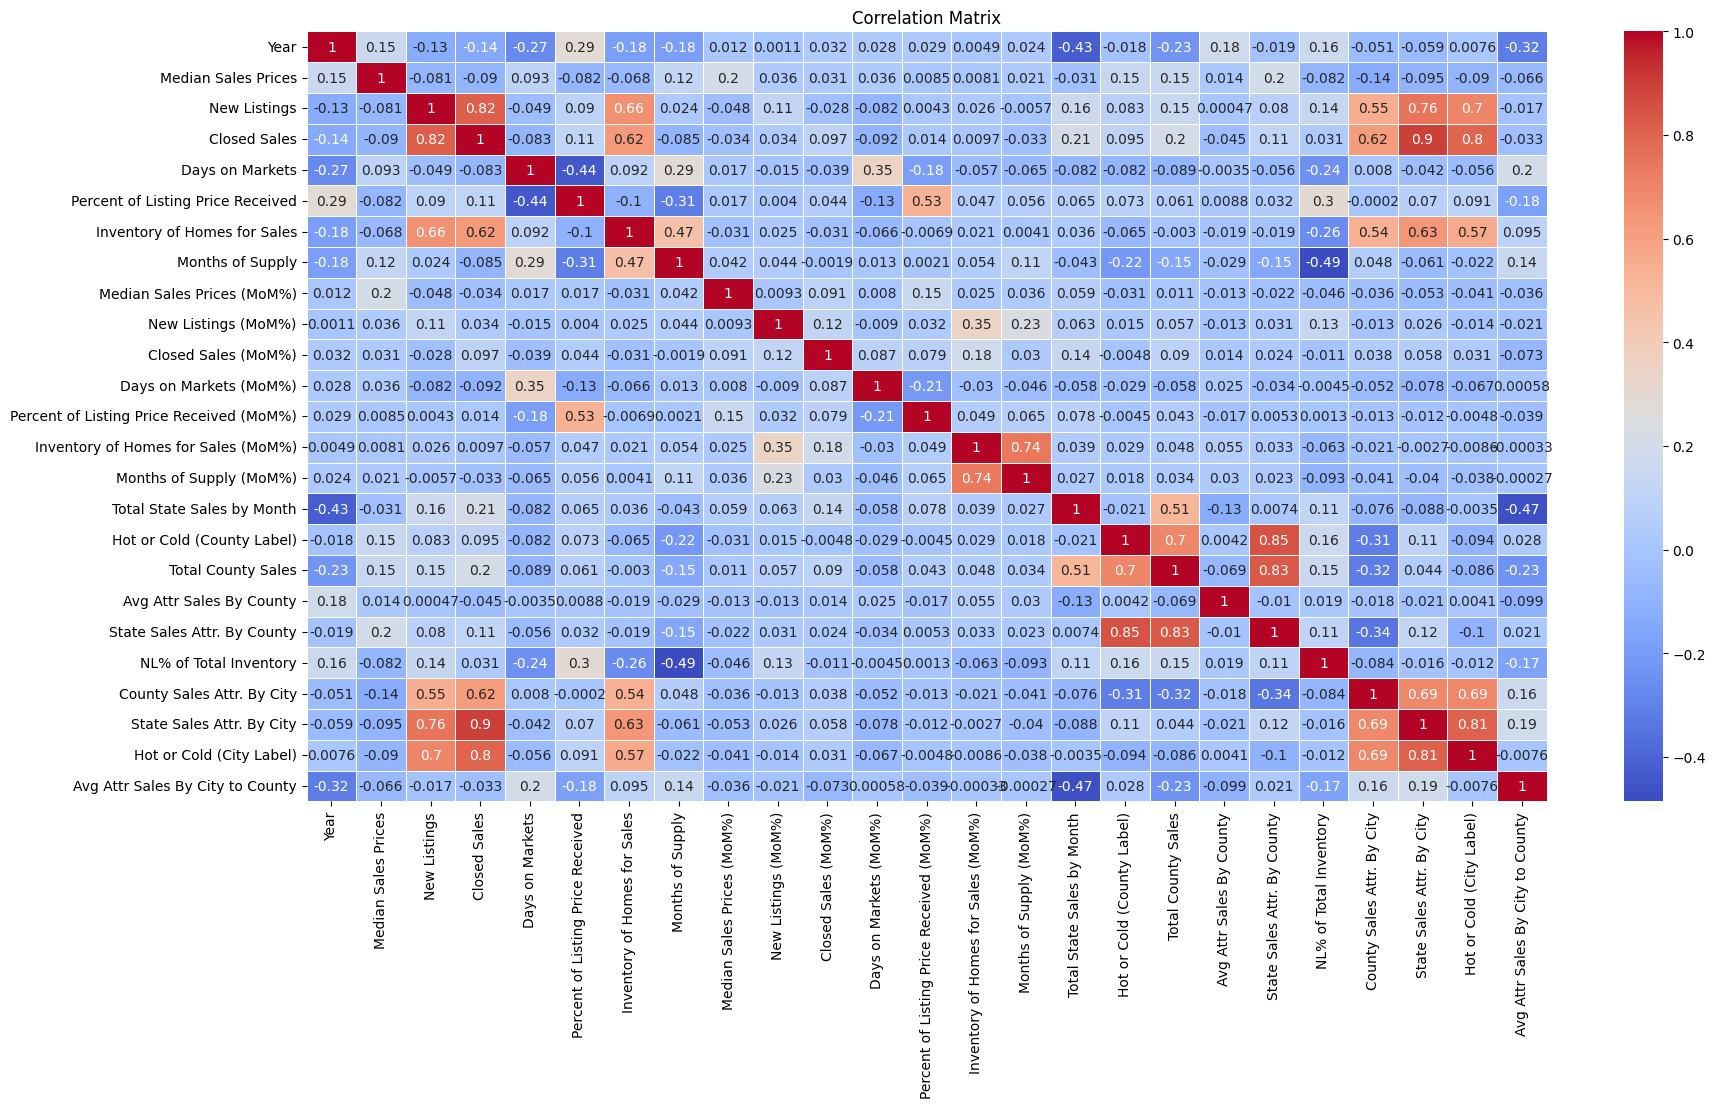

In [149]:
plt.figure(figsize=(20,10))
correlation_matrix = new_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

# Covariance

### Covariance: A measure of how two variables move together with respect to each other

##### Additional Info:


1.   Helpful to determine the type of relationship between variables
2.   Magnitude not easily interpretable
3.   Higher magnitude means more dependent relationship. An increase in one variable would lead to an increase in another variable
4.   A negative covaraince denotes an inverse relationship between the two varaibles

<ipython-input-150-6e701da7aa7e>:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  covariance_matrix = new_df.cov()


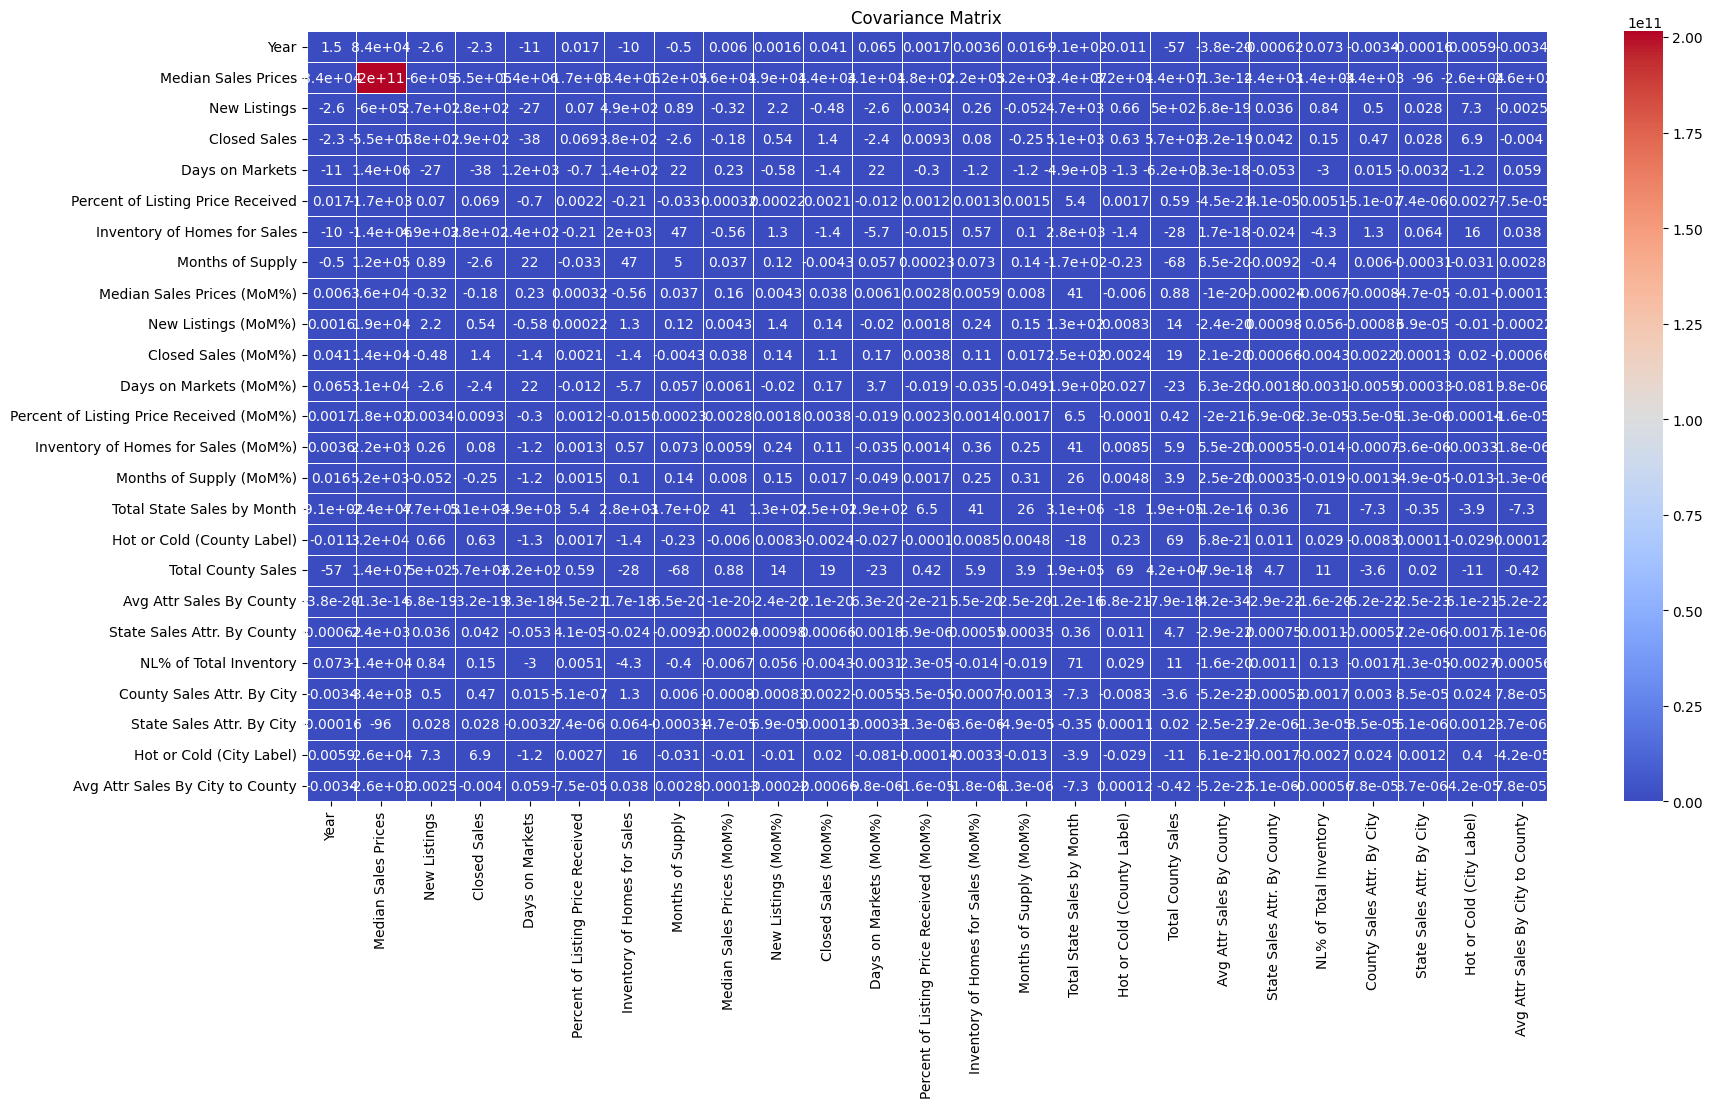

In [150]:
plt.figure(figsize=(20,10))
covariance_matrix = new_df.cov()
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Covariance Matrix')
plt.show()


###VIF

Insert excerpt here about VIF analysis

In [151]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24633 entries, 0 to 480
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Index                                     24633 non-null  object 
 1   City                                      24633 non-null  object 
 2   County                                    24633 non-null  object 
 3   Quarter                                   24633 non-null  object 
 4   Month                                     24633 non-null  object 
 5   Year                                      24633 non-null  int64  
 6   Median Sales Prices                       24633 non-null  float64
 7   New Listings                              24633 non-null  float64
 8   Closed Sales                              24633 non-null  float64
 9   Days on Markets                           24633 non-null  float64
 10  Percent of Listing Price Received   

In [152]:
temp_df = new_df[[column for column in new_df.columns if new_df[column].dtype != 'object']]
# I need to take out the columns which have string dtypes
# from statsmodels.stats.outliers_influence import varaince_inflation_factor
vif_data = pd.DataFrame()
vif_data['Variable'] = temp_df.columns
vif_data['VIF'] = [statsmodels.stats.outliers_influence.variance_inflation_factor(temp_df.values, i) for i in range(temp_df.shape[1])] # ***this 1 may not work for my data Print the VIF table and
# sns.heatmap(vif_data, annot=True, cmap='coolwarm', linewidth=0.5)

# A VIF of 10 will be used as the threshold. Any feature with a VIF above that will be removed
vif_data.round(2)

,Variable,VIF
0,Year,2.72
1,Median Sales Prices,1.22
2,New Listings,4.12
3,Closed Sales,12.34
4,Days on Markets,1.56
5,Percent of Listing Price Received,2.08
6,Inventory of Homes for Sales,3.75
7,Months of Supply,2.44
8,Median Sales Prices (MoM%),1.09
9,New Listings (MoM%),1.23


### Exploratory Data Analysis

*   What is the Median Sales Price of the hottest/coldest cities?
*   Which counties have the hottest/coldest cities?
*   Which qaurter produces the most sales of all time?
*   What is the median attributed state sales by county
*   What is the median attributed county sales by city
*   What is the median attributed county sales by city
*   For the latest year and quarter, see what the Top 5 hottest/coldest cities are and the numerical change between this quarter and last quarter

### Create a historgram counting the amount of times a city in that county was labeled 'Hot'
4.   Plot a line graph of hottest/coldest cities for all time by month (I may need to create a rolling county graph to do this)

In [153]:
hottest_county_mask = (new_df['Hot or Cold (County Label)'] == 1)
target_df = new_df[hottest_county_mask]
group = target_df.groupby('County')['Hot or Cold (County Label)'].sum().sort_values(ascending=False)
group

County
Bergen County        3175
Monmouth County      2281
Morris County        1836
Burlington County    1634
Camden County        1572
Ocean County         1482
Middlesex County     1127
Essex County         1050
Union County          984
Gloucester County     215
Atlantic County       136
Passaic County         19
Somerset County        12
Name: Hot or Cold (County Label), dtype: int64

<Axes: xlabel='County'>

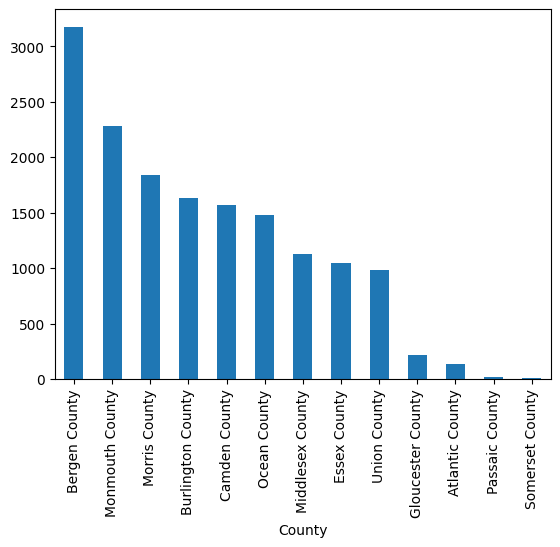

In [154]:
group.plot(kind='bar')

###How many of New Jersey's counties have ever been considerd 'Hot'?

In [155]:
hot_counties = target_df['County'].unique().tolist()
total_counties = new_df['County'].unique().tolist()
print(f'There are {len(total_counties)} in New Jersey')
print(f"{len(hot_counties)/len(total_counties)} of New Jersey's counties have been consider 'Hot' at least one time from 2019 to 2023")
print(f"The following counties have never been considered 'Hot': {set(total_counties).difference(set(hot_counties))}")

There are 21 in New Jersey
0.6190476190476191 of New Jersey's counties have been consider 'Hot' at least one time from 2019 to 2023
The following counties have never been considered 'Hot': {'Cape May County', 'Mercer County', 'Sussex County', 'Hunterdon County', 'Hudson County', 'Salem County', 'Warren County', 'Cumberland County'}


###Top 50 Most Consistantly Labeled 'Supernova' Cities (All Time)

In [156]:
# Create GroupBy object for new_df['Hot or Cold (County Label)'] == 2
supernova_city_mask = (new_df['Hot or Cold (City Label)'] > 1)
target_df = new_df[supernova_city_mask]
group = target_df.groupby(['County'])['Hot or Cold (City Label)'].count().sort_values(ascending=False)
group.head(50)

County
Ocean County         301
Middlesex County     203
Camden County        175
Essex County         174
Monmouth County      154
Burlington County    138
Passaic County       129
Union County         121
Mercer County        120
Cumberland County     98
Gloucester County     97
Atlantic County       69
Somerset County       67
Sussex County         65
Cape May County       53
Bergen County         52
Morris County         45
Hudson County          6
Salem County           3
Name: Hot or Cold (City Label), dtype: int64

In [157]:
# Create GroupBy object for new_df['Hot or Cold (County Label)'] == 2
supernova_city_mask = (new_df['Hot or Cold (City Label)'] > 1)
target_df = new_df[supernova_city_mask]
group = target_df.groupby(['County', 'City'])['Hot or Cold (City Label)'].count().sort_values(ascending=False)
group.head(50)

County             City                     
Burlington County  Willingboro Twp              51
Monmouth County    Middletown Twp               50
Passaic County     Wayne Twp                    50
Cumberland County  Vineland City                49
Ocean County       Stafford Twp                 48
Camden County      Winslow Twp                  48
Middlesex County   Edison Twp                   48
Camden County      Gloucester Twp               48
Ocean County       Jackson Twp                  48
Passaic County     Clifton City                 47
Ocean County       Lacey Twp                    47
Atlantic County    Egg Harbor Twp               47
Union County       Union Twp                    47
Mercer County      Hamilton Twp                 46
Camden County      Cherry Hill Twp              46
Ocean County       Brick Twp                    45
Essex County       West Orange Twp              45
Mercer County      Trenton City                 44
Cape May County    Lower Twp         

### Top 50 Most Consistantly Labeled 'Hot' Cities (All Time)

In [158]:
hottest_city_mask = (new_df['Hot or Cold (City Label)'] == 1)
target_df = new_df[hottest_city_mask]
group = target_df.groupby(['County'])['Hot or Cold (City Label)'].count().sort_values(ascending=False)
group.head(50)

County
Atlantic County      420
Union County         404
Somerset County      388
Morris County        341
Gloucester County    332
Essex County         331
Sussex County        253
Mercer County        252
Burlington County    239
Passaic County       233
Middlesex County     219
Cape May County      210
Hunterdon County     191
Monmouth County      164
Hudson County        151
Warren County        125
Salem County         119
Camden County        112
Ocean County         110
Bergen County         68
Cumberland County     60
Name: Hot or Cold (City Label), dtype: int64

In [159]:
hottest_city_mask = (new_df['Hot or Cold (City Label)'] == 1)
target_df = new_df[hottest_city_mask]
group = target_df.groupby(['County', 'City'])['Hot or Cold (City Label)'].count().sort_values(ascending=False)
group.head(50)

County             City                 
Somerset County    Warren Twp               48
Hunterdon County   Raritan Twp              48
Warren County      Phillipsburg Town        48
Hunterdon County   Readington Twp           47
Mercer County      Lawrence Twp             47
Atlantic County    Hamilton Twp             47
Sussex County      Wantage Twp              46
Salem County       Pennsville Twp           46
Mercer County      Hopewell Twp             45
Cape May County    Ocean City               45
Somerset County    Bernards Twp             45
Passaic County     Paterson City            45
Hudson County      Jersey City              45
Cape May County    Middle Twp               45
Mercer County      West Windsor Twp         44
Somerset County    Hillsborough Twp         44
Atlantic County    Margate City             43
Gloucester County  Glassboro Boro           43
Atlantic County    Atlantic City            42
Somerset County    North Plainfield Boro    42
Gloucester County  

### Top 50 Most Consistantly Labeled 'Cold' Cities (All Time)

In [160]:
# I see some cities here that I would have thought were 'Hot' (ex: Morristown in Morris County)
hottest_city_mask = (new_df['Hot or Cold (City Label)'] == 0)
target_df = new_df[hottest_city_mask]
group = target_df.groupby(['County', 'City'])['Hot or Cold (City Label)'].count().sort_values(ascending=False)
group.head(50)

County             City                     
Bergen County      Maywood Boro                 52
Morris County      Mendham Boro                 52
                   Boonton Town                 52
Bergen County      Franklin Lakes Boro          51
Morris County      Mendham Twp                  51
Bergen County      Saddle Brook Twp             51
                   Washington Twp               51
Monmouth County    Manasquan Boro               51
Camden County      Audubon Boro                 51
                   Berlin Twp                   51
Monmouth County    Rumson Boro                  51
Middlesex County   South Amboy City             51
Ocean County       Ocean Twp                    51
Morris County      Hanover Twp                  51
Monmouth County    Asbury Park City             51
                   Colts Neck Twp               51
Morris County      Morristown Town              50
Monmouth County    Keyport Boro                 50
Burlington County  Chesterfield Twp  

### What Is he Mean Median Sales Price for the Top 100 Cities Labled 'Hot'

In [161]:
hottest_city_mask = (new_df['Hot or Cold (City Label)'] != 0)
target_df = new_df[hottest_city_mask]
group = target_df.groupby(['County', 'City']).agg({'Hot or Cold (City Label)': 'count', 'Median Sales Prices': 'mean'}).sort_values(by='Hot or Cold (City Label)', ascending=False)
results = group.head(100)
results.describe().round(2)

,Hot or Cold (City Label),Median Sales Prices
count,100.00,100.00
mean,46.31,480524.79
std,3.93,238797.53
min,38.00,162137.23
25%,43.00,325002.43
50%,48.00,434551.01
75%,49.00,551847.66
max,52.00,1480703.14


### What Quarter Produces the Most Sales? (All Time)

In [162]:
group = new_df.groupby('Quarter')['Closed Sales'].sum().sort_values(ascending=False)
group

Quarter
Q3    91641.0
Q4    89703.0
Q2    75398.0
Q1    55629.0
Name: Closed Sales, dtype: float64

###What Month Produces the Most Sales? (All Time)

In [163]:
group = new_df.groupby('Month')['Closed Sales'].sum().sort_values(ascending=False)
group

Month
October      33772.0
September    31770.0
August       30132.0
June         29860.0
July         29739.0
December     28123.0
November     27808.0
May          23574.0
March        22733.0
April        21964.0
January      17774.0
February     15122.0
Name: Closed Sales, dtype: float64

In [164]:
target_columns = [column for column in new_df.columns if (new_df[column].dtype != 'object' and 'MoM' not in column and 'Total' not in column and column not in ['Avg Attr Sales By County', 'Year'])]
target_columns

['Median Sales Prices',
 'New Listings',
 'Closed Sales',
 'Days on Markets',
 'Percent of Listing Price Received',
 'Inventory of Homes for Sales',
 'Months of Supply',
 'Hot or Cold (County Label)',
 'State Sales Attr. By County',
 'County Sales Attr. By City',
 'State Sales Attr. By City',
 'Hot or Cold (City Label)',
 'Avg Attr Sales By City to County']

In [165]:
final_df = new_df[target_columns]

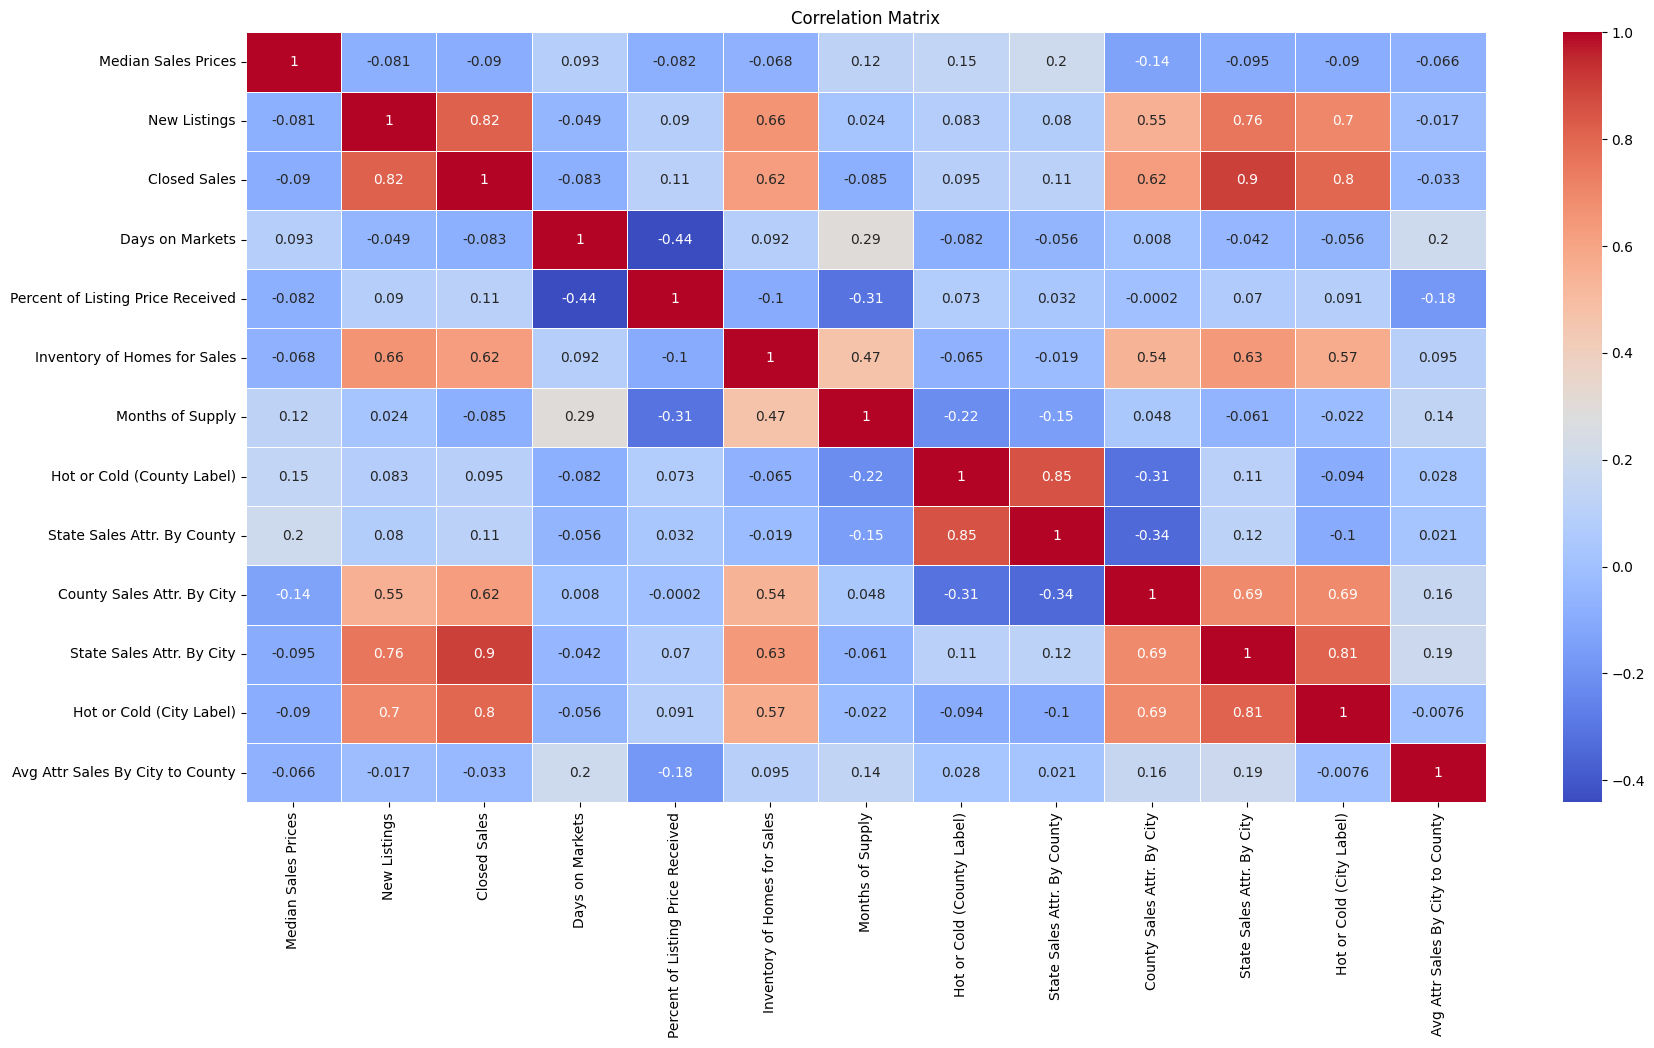

In [166]:
plt.figure(figsize=(20,10))
correlation_matrix = final_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

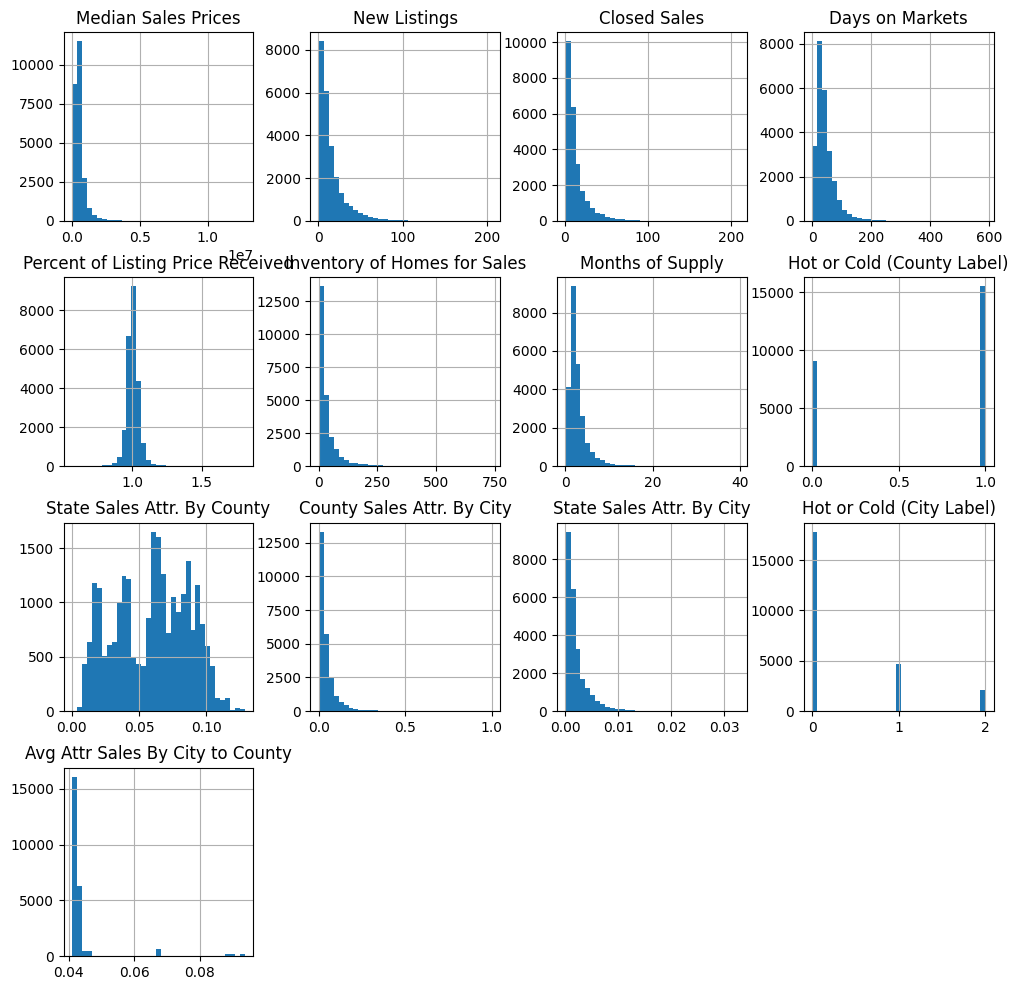

In [167]:
final_df.hist(bins=35, figsize=(12,12))
plt.show()

###Machine Learning (Classification)


Use the following algorithms to classifiy if a city is 'Hot'
- Logistic Regression
- Support Vector Machine (SVM)
- k-Nearest Neighbor
- Decision Tree Classifier




In [169]:
# It has been determines that the columns below may best be able to help classify a city
new_data = final_df[['New Listings',
 'Closed Sales',
 'Inventory of Homes for Sales',
 'County Sales Attr. By City', 'State Sales Attr. By City',
 'Hot or Cold (City Label)']]

#Transformations

#####After visualizing the relationships between the dependent and independent variables, as well as the distribution of the independent variables, it is clear that we need to implement some transformations to create a more normal distribution amongst the data and standardize the scales.

#####There needs to be a global transformaton as well as a local transformation used on the data. The global transformation used will be Standardization. The Standardization scaler will squash these values down to a smaller range but wont change the shape or the distribution of the data.

#####However, before using the Standardization transformation, the data needs to be evenly distributed. Based on the historgram plots, the only data that seems to be evenly distributed in the PoLPR. All other feature columns to have heavy tails (right or positively skewed). When dealing with right skewed data, it is best to use log-transforms to help make that distribution more even.

In [170]:
# Create a train, test, split on the data before initiating the transforms
# mask = new_data['Hot or Cold (City Label)'] < 2
# initial_run = new_data[mask]
y = new_data['Hot or Cold (City Label)']
x = new_data.drop(columns=['Hot or Cold (City Label)'])

# It is industry standard to use an 80/20 split for the test and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
orginal_y_train = y_train.copy()


In [171]:
# Create a sklearn pipeline to apply the log-transform on the columns which are right-skewed then StandardScalar()
# Use the FunctionTransformer method to apply the np.log transform
# Use the ColumnTransformer() to properly apply the transforms  to the target columns based on what it needs

standarizer = StandardScaler()
log_transform = FunctionTransformer(np.log, inverse_func=np.exp)
log_pipeline = make_pipeline(log_transform, standarizer)
default_pipeline = make_pipeline(standarizer)

log_target_features = ['New Listings', 'Closed Sales', 'Inventory of Homes for Sales', 'County Sales Attr. By City', 'State Sales Attr. By City']
default_target_features = ['New Listings', 'Closed Sales', 'Inventory of Homes for Sales', 'County Sales Attr. By City', 'State Sales Attr. By City']

pre_processing = ColumnTransformer([('log', log_pipeline, log_target_features)])
default_pre_processing = ColumnTransformer([('default', default_pipeline, default_target_features)])

In [172]:
def target_label_transformer(labels, inverse=False, standard_func=None, standard_only='No'):
  standarizer= StandardScaler()

  if standard_only == 'No':
    if inverse is False:
      trans_label = log_transform.fit_transform(labels)
      trans_label = standarizer.fit_transform(trans_label.to_frame())

      return trans_label, standarizer

    elif inverse is True:
      trans_label = standard_func.inverse_transform(labels)
      trans_label = np.exp(trans_label)

      return trans_label
  else:
    if inverse is False:
      trans_label = standarizer.fit_transform(labels.to_frame())

      return trans_label, standarizer

    elif inverse is True:
      trans_label = standard_func.inverse_transform(labels)

      return trans_label


### Standardized Features

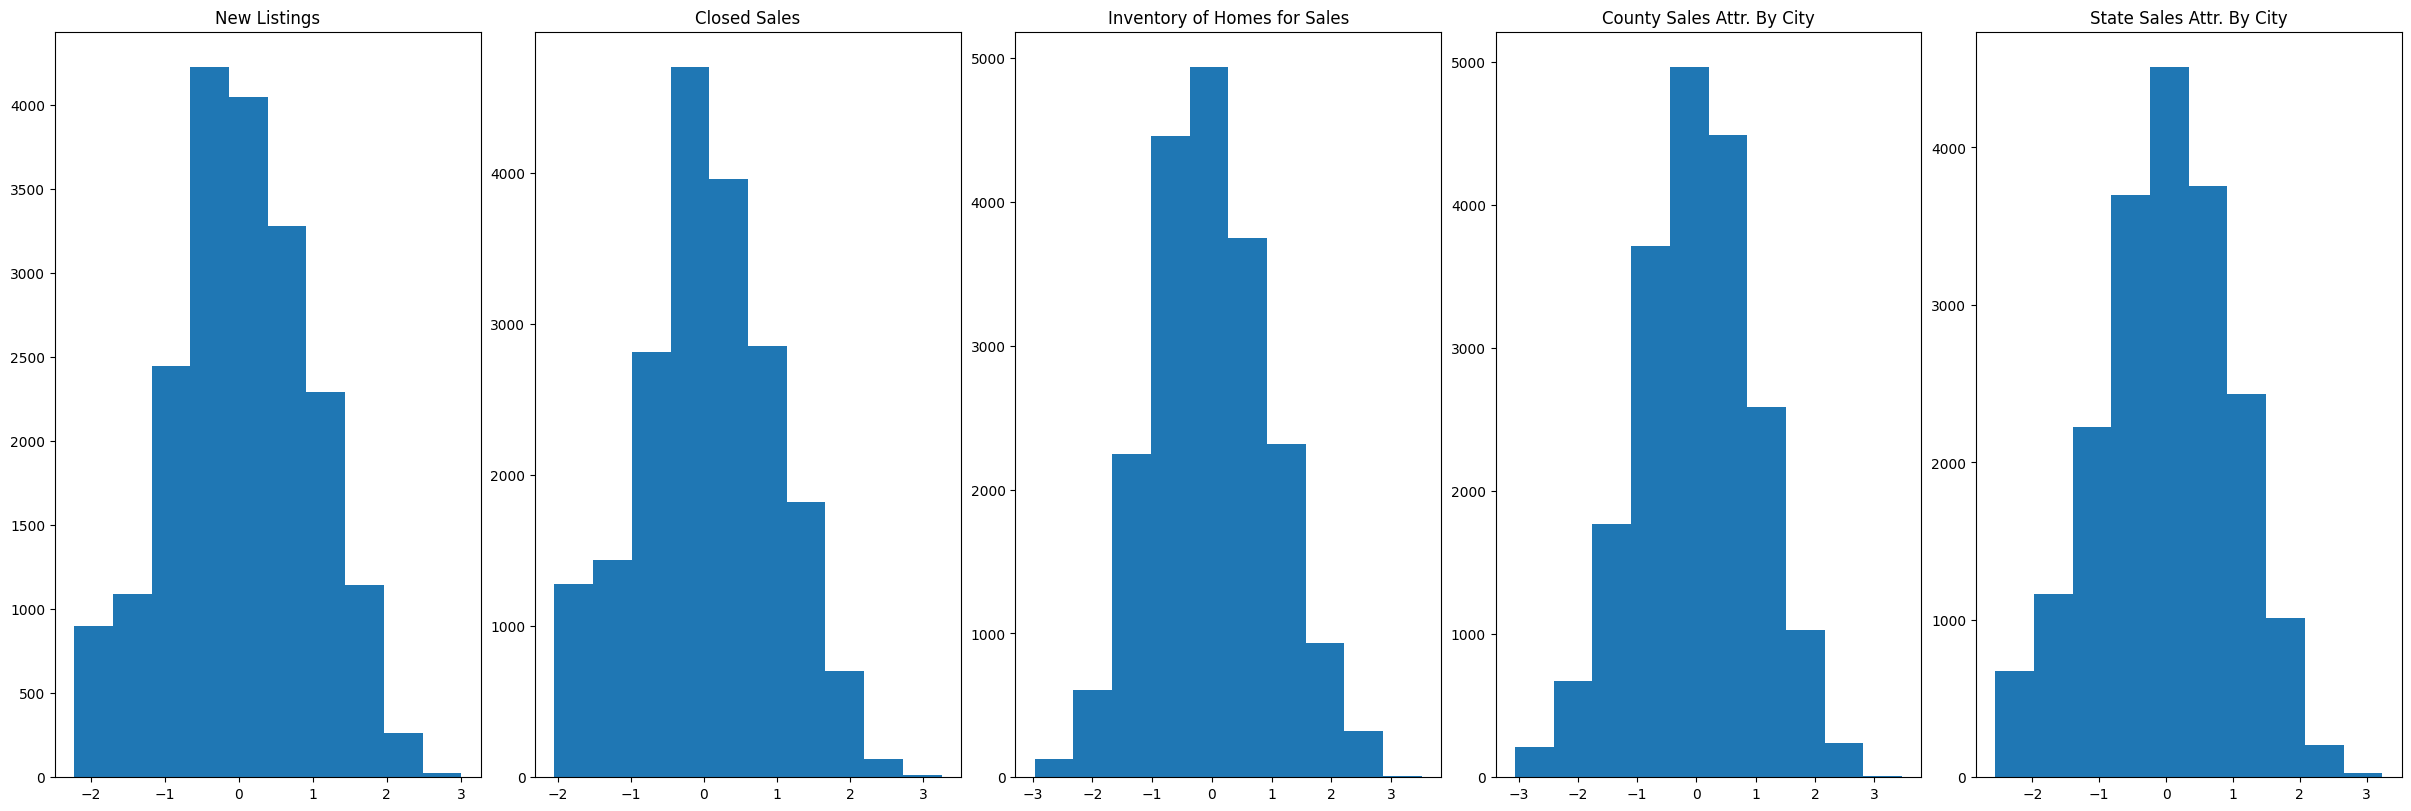

In [173]:
fig, axs = plt.subplots(ncols=len(log_target_features), figsize=(24,8), layout='constrained')
for idx, col in enumerate(log_target_features):
  #td means transformed data
  td, standarizer_func = target_label_transformer(x_train[col])
  axs[idx].hist(td)
  axs[idx].set_title(col)

###Scatterplots of City Labels vs. other feature elements to check for correlation

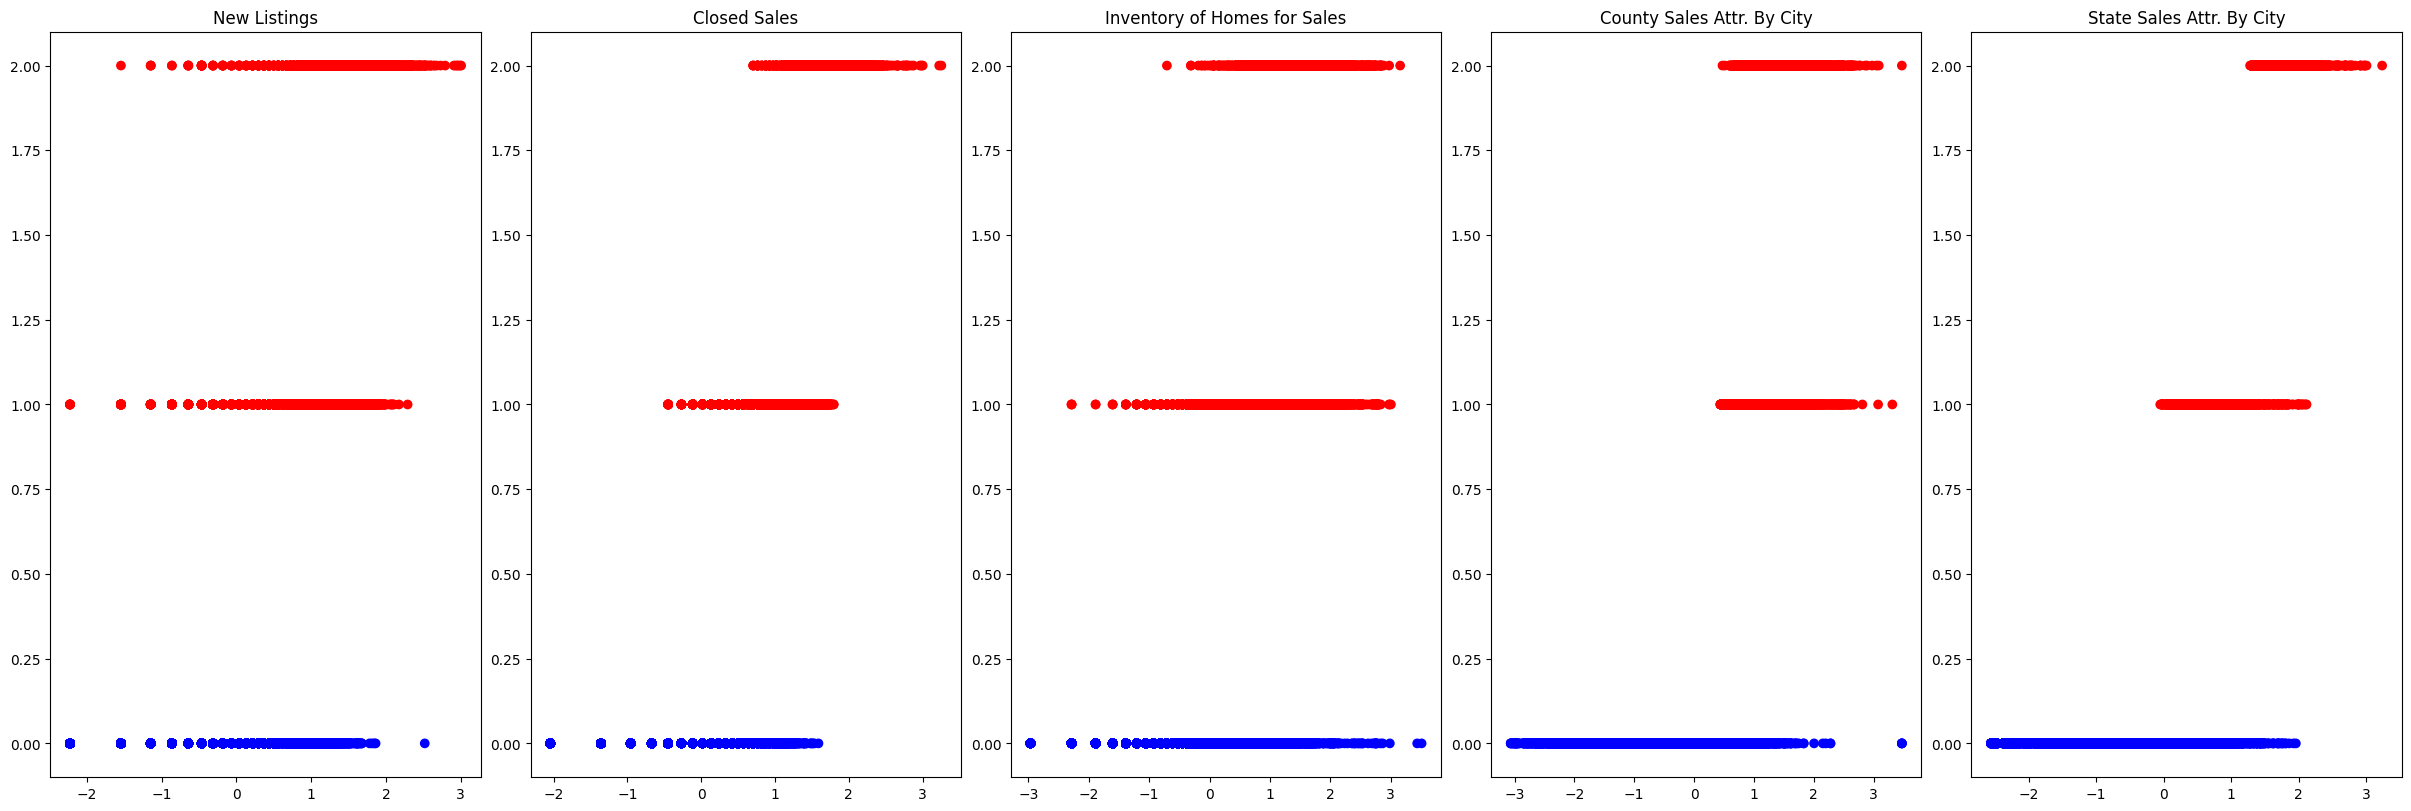

In [174]:
# target, standarizer_func = target_label_transformer(orginal_y_train)
fig, axs = plt.subplots(ncols=len(log_target_features), figsize=(24,8), layout='constrained')
for idx, col in enumerate(x_train.columns):
  #td means transformed data
  td, standarizer_func = target_label_transformer(x_train[col])
  color= ['blue' if l == 0 else 'red' for l in orginal_y_train]

  axs[idx].scatter(td, orginal_y_train, c=color)
  axs[idx].set_title(col)

In [175]:
# Create another pipeline which links the pre-processing var and the LinearRegression() method then train the model on the training data and score it
x_prepared = pre_processing.fit_transform(x_train)

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
""""
Conducted previously

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'random_state': ['None', 20],


}

optimized_clf = GridSearchCV(clf, param_grid=param_grid, scoring='r2', refit=True, cv=5, return_train_score=True)
optimized_clf.fit(x_prepared, y_train)

optimized_clf.best_params_ returned the following dict as the best parameters:

{'C': 0.005,
 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l1',
 'random_state': 20,
 'solver': 'liblinear'}

optimized_clf.best_score_: 0.9137569396807539
"""

'"\nConducted previously\n\nparam_grid = {\n    \'penalty\': [\'l1\', \'l2\', \'elasticnet\'],\n    \'C\': [0.001, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0],\n    \'fit_intercept\': [True, False],\n    \'class_weight\': [None, \'balanced\'],\n    \'solver\': [\'lbfgs\', \'liblinear\', \'newton-cg\', \'newton-cholesky\', \'sag\', \'saga\'],\n    \'random_state\': [\'None\', 20],\n\n\n}\n\noptimized_clf = GridSearchCV(clf, param_grid=param_grid, scoring=\'r2\', refit=True, cv=5, return_train_score=True)\noptimized_clf.fit(x_prepared, y_train)\n\noptimized_clf.best_params_ returned the following dict as the best parameters:\n\n{\'C\': 0.005,\n \'class_weight\': None,\n \'fit_intercept\': True,\n \'penalty\': \'l1\',\n \'random_state\': 20,\n \'solver\': \'liblinear\'}\n\noptimized_clf.best_score_: 0.9137569396807539\n'

In [177]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0],
    'fit_intercept': [True, False],
    'multi_class': ['ovr', 'multinominal'],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'random_state': ['None', 20]}

clf = LogisticRegression()

In [178]:
optimized_clf = GridSearchCV(clf, param_grid=param_grid, scoring='r2', refit=True, cv=5, return_train_score=True)
optimized_clf.fit(x_prepared, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12800 fits failed out of a total of 14400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    esti

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.25, 0.5,
                               0.75, 1.0],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'multi_class': ['ovr', 'multinominal'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': ['None', 20],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             return_train_score=True, scoring='r2')

In [179]:
optimized_clf.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 20,
 'solver': 'liblinear'}

In [180]:
optimized_clf.best_score_

0.8123963579616594

In [ ]:
# clf = LogisticRegression(penalty='l1', class_weight=None, C=0.005, fit_intercept=True, random_state=20, solver='liblinear')
# clf.fit(x_prepared, y_train)

LogisticRegression(C=0.005, penalty='l1', random_state=20, solver='liblinear')

In [181]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

In [182]:
# This space will be used to create the visual plot of the LogisticRegression

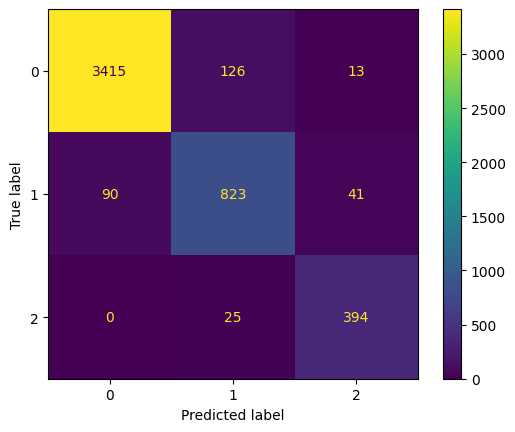

In [183]:
# You only use .transform() for the test data because the transformer already holds the parameters found during the fit in the training data
# This can be directly applied on the test data
predictions = optimized_clf.predict(pre_processing.transform(x_test))

cm = confusion_matrix(y_test, predictions, labels=optimized_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=optimized_clf.classes_)
disp.plot()


In [184]:
# Create a classification report for the LogisticRegression results

print(classification_report(y_test, predictions, labels=optimized_clf.classes_))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3554
           1       0.84      0.86      0.85       954
           2       0.88      0.94      0.91       419

    accuracy                           0.94      4927
   macro avg       0.90      0.92      0.91      4927
weighted avg       0.94      0.94      0.94      4927



###k-Nearest Neighbors Regression

Explain the reasoning for doing a KNN Regression for non-parametrized analysis. Better to uncover trends where no correlation is apparent.

Explain the Curse of Dimensionality and why I cant use all of the features for a KNN analysis and that I'm choosing the ones in which I thin is more important

In [ ]:
"""
Conducted previously

knn_param_grid = {
    'n_neighbors': [i for i in range(1,35)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30],

}

k_neighbor = GridSearchCV(model, param_grid=knn_param_grid, scoring='r2', refit=True, cv=5, return_train_score=True)

Log-transformed + Standardized k-Nearest Neighbor data return the following dict of best params:
{'algorithm': 'ball_tree',
 'leaf_size': 30,
 'n_neighbors': 16,
 'weights': 'distance'}

 Calculate the r2 score for this one

Standardized k-Nearest Neighbor data return the following dict of best params:
{'algorithm': 'ball_tree',
 'leaf_size': 30,
 'n_neighbors': 20,
 'weights': 'distance'}

 k_neighbor.best_score_: 0.8578261551244113







In [185]:
knn_param_grid = {
    'n_neighbors': [i for i in range(10,35)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30]}

In [186]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
# We will create a display which creates a visualization of the decision boundaries
k_neighbor = KNeighborsClassifier()

In [187]:
# Train/test and test/validate split the data. Use the validation set to discover the optimal k value which leads to the closest y-hat
# new_x = x[['Closed Sales', 'Days on Markets', 'Months of Supply']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
x_validate, x_train, y_validate, y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=57)

In [188]:
# Unsure of whether log transforming the data is necessary to improve the k-nearest Neighbor model so I will try both

x_prepared = pre_processing.fit_transform(x_train)
x_prepared1 = default_pre_processing.fit_transform(x_train)

In [189]:
k_neighbor = GridSearchCV(k_neighbor, param_grid=knn_param_grid, scoring='r2', refit=True, cv=5, return_train_score=True)

In [190]:
# Log-transformed + Standardized k-Nearest Neighbor GridSearchCV
k_neighbor.fit(x_prepared, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30],
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='r2')

In [191]:
k_neighbor.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 30,
 'n_neighbors': 12,
 'weights': 'distance'}

In [192]:
k_neighbor.best_score_

0.885706611980593

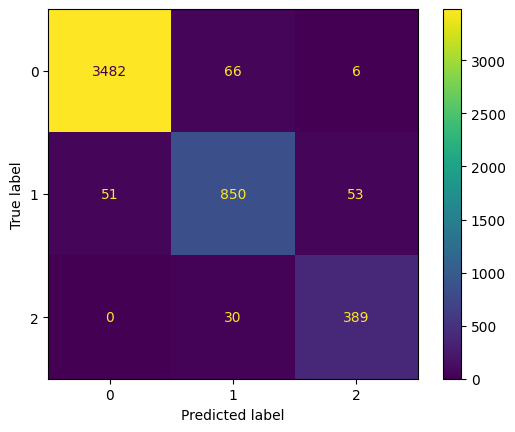

In [193]:
predictions = k_neighbor.predict(pre_processing.transform(x_test))

cm = confusion_matrix(y_test, predictions, labels=k_neighbor.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=k_neighbor.classes_)
disp.plot()

In [194]:
# Create a classification report for the k-Nearest Neighbors results

print(classification_report(y_test, predictions, labels=k_neighbor.classes_))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3554
           1       0.90      0.89      0.89       954
           2       0.87      0.93      0.90       419

    accuracy                           0.96      4927
   macro avg       0.92      0.93      0.92      4927
weighted avg       0.96      0.96      0.96      4927



In [ ]:
"""
columns = [i for i in x.columns]
_, axs = plt.subplots(ncols=len(columns), figsize=(12,5), layout='constrained')

for ax, xaxis in zip(axs, columns):
  disp = DecisionBoundaryDisplay.from_estimator(
    k_neighbor_log_std, pre_processing.transform(x_test),
    response_method='predict',
    plot_method='pcolormesh',
    xlabel=xaxis,
    ylabel=y.columns,
    alpha=0.5
    ax=ax)
  scatter = disp.ax_.scatter(pre_processing.transform(x_validate), y_validate, c=y, edgecolors='k')
  disp.ax_.legend(scatter.legend_elements()[0], #Something needs to go here, loc='lower left', title='Classes')
"""

#START FROM HERE!!!
### Next Steps:
- Construct the DecisionTreeClassifier and SVM
- Do GridSearch for both
- Run the ROC and AUC after getting resutls from the SVM, KNN, and DecisionTreeClassifier

In [195]:
# Construct a DecisionTreeClassifier and a Gradient Boosted Classifier
# Use Histogram-based Gradient Boosted Classifier becasue I have over 10s of thousands of samples and the
# compute time will be quicker
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [196]:
dtc_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [i for i in range(1, 20)],
    'min_samples_leaf': [i for i in range(2, 20)],
    'max_depth': [1, 2, 3, 4, 5],
    'class_weight': [None, 'balanced'],

}

In [197]:
optimized_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_param_grid, scoring='r2', refit=True, cv=5, return_train_score=True)

In [198]:
optimized_dtc.fit(x_train, y_train)
optimized_dtc.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5400 fits failed out of a total of 102600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5400 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in 

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'best'}

In [199]:
optimized_dtc.best_score_

0.9196390591153808

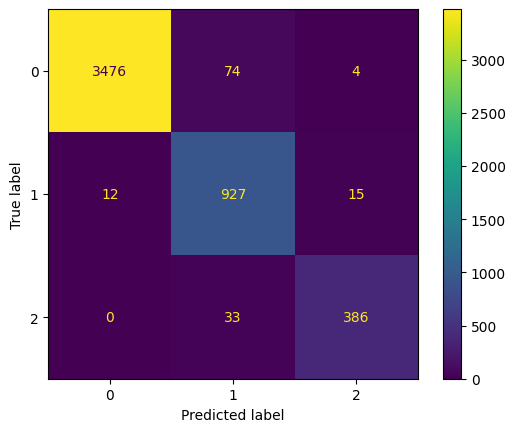

In [200]:
predictions = optimized_dtc.predict(x_test)

cm = confusion_matrix(y_test, predictions, labels=optimized_dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=optimized_dtc.classes_)
disp.plot()

In [201]:
# Create a classification report for the DecisionTreeClassifier results

print(classification_report(y_test, predictions, labels=optimized_dtc.classes_))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3554
           1       0.90      0.97      0.93       954
           2       0.95      0.92      0.94       419

    accuracy                           0.97      4927
   macro avg       0.95      0.96      0.95      4927
weighted avg       0.97      0.97      0.97      4927



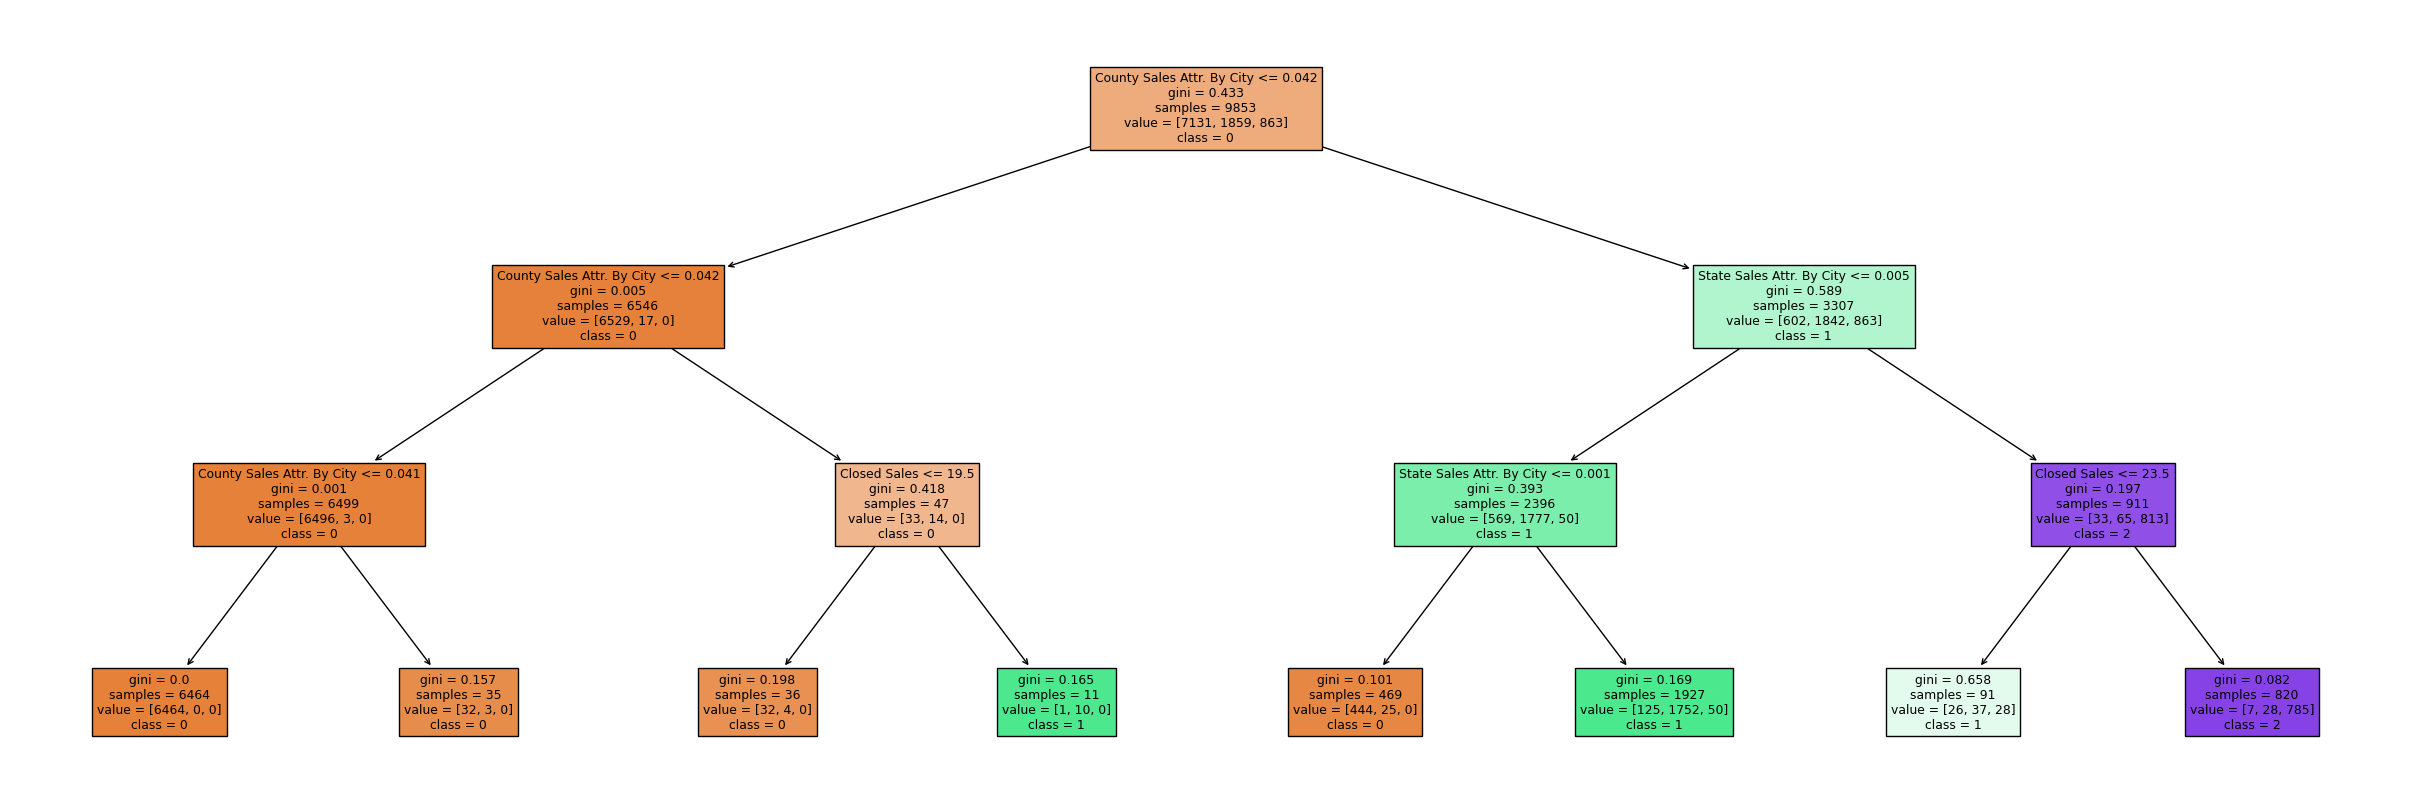

In [205]:
from sklearn import tree
fig, axs = plt.subplots(figsize=(24,8), layout='constrained')
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter='best')
clf.fit(x_train, y_train)
tree.plot_tree(clf, feature_names=['New Listings', 'Closed Sales', 'Inventory of Homes for Sales', 'County Sales Attr. By City', 'State Sales Attr. By City'], class_names=['0', '1', '2'], filled=True)
plt.show()

In [ ]:
# Maybe this is for HBGB Classifier?

dtc_param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [1, 2, 3, 4, 5],
    'class_weight': [None, 'balanced'],

}

In [ ]:
# Construct the Support Vector Machine Classifier (SVMc)

###Results

#####Multiple Linear Regression doesnt seem to be the best generalizing function to find the effects of different independent variables on the Median Sales Price. Even looking at each individual independent feature vs Median Sale Prices shows no indication of linear correleation between the variables. I believe this checks out well with the correlation matrix generated in the beginning of the project. I will need to choose a stronger model to determine any type of insights or trends

###Questions

#####1) Can I preview the correlation matrix to determine the relationship between the dependent and independent variables to determine if this is a good candidate for multiple linear regression?
#####2) Can data have very little correlation but very high covariance?
#####3) Would adding the month and year varaibles to the model make a difference?
#####4) Are there any previous steps that were done incorrectly to lead me to these conclusions?
#####5) Would using a regualrized(Ridge or Lasso) regression model make a difference?
#####6) Is this bad data? Is there any feature engineering I can do to improve the data?


In [ ]:
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
# !jupyter nbconvert --to pdf /content/drive/MyDrive/Colab\ Notebooks/NJRealtors_ML_Project.ipynb